<a href="https://colab.research.google.com/github/IvanCampos11/DS-Unit-2-Kaggle-Challenge/blob/master/module4-classification-metrics/LS_DS_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
train, val = train_test_split(train, train_size=0.80, test_size=0.20, stratify=train['status_group'], random_state=42)

In [5]:
def wrangle(X):
    X = X.copy()
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
            
    duplicates = ['quantity_group', 'payment_type']
    X = X.drop(columns=duplicates)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()
    
    return X

In [6]:
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [7]:
target = 'status_group'
train_features = train.drop(columns=[target])
numeric_features = train_features.select_dtypes(include='number').columns.tolist()
cardinality = train_features.select_dtypes(exclude='number').nunique()
categorical_features = cardinality[cardinality <= 50].index.tolist()
features = numeric_features + categorical_features

In [8]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [ ]:
%%time
pipeline = make_pipeline(
    OrdinalEncoder(drop_invariant=True),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    RandomForestClassifier(
        n_jobs=1,
        random_state=42,
        n_estimators=9,
    )
)

param_distributions = {
    'simpleimputer__strategy': ['mean', 'median'],
    'randomforestclassifier__criterion': ('gini', 'entropy'),
    'randomforestclassifier__max_depth': (8,10,12,14,15,16,20,25),
    'randomforestclassifier__max_features': (9,12,13,14,15,16),
    'randomforestclassifier__min_samples_split': (2,4,6,8,10)
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=240,
    cv=7,
    scoring='accuracy',
    verbose=1,
    return_train_score=True,
    n_jobs=-1,
)

search.fit(X_train,y_train)

print('Best Score:',search.best_score_)
print('Best param:',search.best_params_)
print('Best estimaator:', search.best_estimator_)

In [9]:
%%time
pipe = make_pipeline(
    OrdinalEncoder(drop_invariant=True),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='entropy',
                                        max_depth=20, max_features=12,
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1,
                                        min_samples_split=10,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=999, n_jobs=-1,
                                        oob_score=False, random_state=42,
                                        verbose=1, warm_start=False)
    )

pipe.fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  2.1min


CPU times: user 5min 16s, sys: 1.04 s, total: 5min 17s
Wall time: 2min 41s


[Parallel(n_jobs=-1)]: Done 999 out of 999 | elapsed:  2.7min finished


In [10]:
print('training accuracy:', pipe.score(X_train, y_train))
print('validation accuracy:', pipe.score(X_val, y_val))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.6s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    3.7s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    6.5s
[Parallel(n_jobs=2)]: Done 999 out of 999 | elapsed:    8.2s finished


training accuracy: 0.9013047138047138


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    1.7s


validation accuracy: 0.8134680134680135


[Parallel(n_jobs=2)]: Done 999 out of 999 | elapsed:    2.1s finished


In [11]:
X_train, y_train = pd.concat([X_train,X_val]), pd.concat([y_train,y_val])

In [12]:
pipe.fit(X_train,y_train)
print('training accuracy:', pipe.score(X_train, y_train))
print('validation accuracy:', pipe.score(X_val, y_val))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 999 out of 999 | elapsed:  3.4min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    2.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    4.6s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    8.2s
[Parallel(n_jobs=2)]: Done 999 out of 999 | elapsed:   10.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


training accuracy: 0.9007744107744108


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    1.9s


validation accuracy: 0.9040404040404041


[Parallel(n_jobs=2)]: Done 999 out of 999 | elapsed:    2.3s finished


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    1.8s
[Parallel(n_jobs=2)]: Done 999 out of 999 | elapsed:    2.3s finished


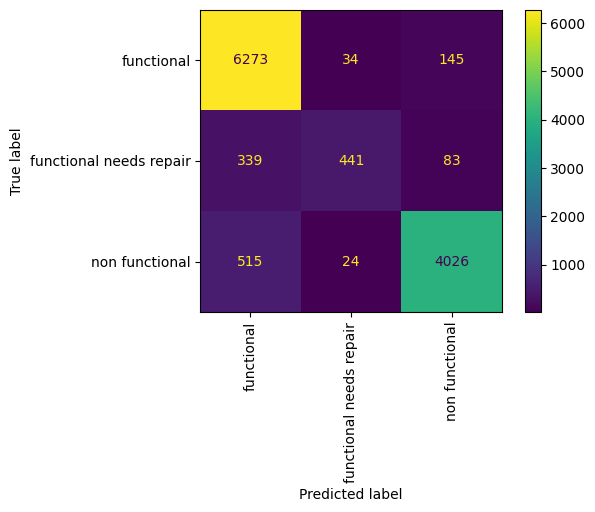

In [17]:
from sklearn.metrics import plot_confusion_matrix, classification_report

plt.rcParams['figure.dpi'] = 100
plot_confusion_matrix(pipe, X_val, y_val, values_format='.0f', xticks_rotation='vertical')

In [13]:
y_pred = pipe.predict(X_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    1.3s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    2.4s
[Parallel(n_jobs=2)]: Done 999 out of 999 | elapsed:    2.9s finished


In [14]:
DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('your-submission-filename.csv', index=False)

In [15]:
from google.colab import files
files.download('your-submission-filename.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>